# Plotting animated GIFs from time series imagery

**What does this notebook do?** 

This notebook demonstrates how to import a time series of DEA cloud-free Landsat imagery from multiple sensors (i.e. Landsat 5, 7 and 8) as an xarray dataset, and then plot the data as an animated time series GIF and a transitioning/fading GIF that compares two timesteps. Animations can be produced as either GIFs or MP4s for any area in Australia using a standard datacube query.

**Required inputs**

This example uses three external functions called `load_clearlandsat`, `animated_timeseries` and `animated_fade`. These functions are available in the Scripts folder of the [dea-notebooks Github repository](https://github.com/GeoscienceAustralia/dea-notebooks/tree/master/Scripts). Note that these functions have been developed by DEA users, not the DEA development team, and so are provided without warranty. If you find an error or bug in the functions, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated function back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** May 2018

**Author:** Robbi Bishop-Taylor

In [1]:
# Import modules
import datacube 
import sys
import os

# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../Scripts')
import DEADataHandling
import DEAPlotting

# Set up datacube instance
# dc = datacube.Datacube(app='Time series animation')
dc = datacube.Datacube(config='/home/561/rt1527/preprod_dc.conf')

Failed to resolve driver datacube.plugins.index::s3aio_index


## Set up datacube query
Define the query bounds for datacube extraction using a dict. This should include `x` and `y` limits, potentially a list of `measurements` (i.e. the bands you want to extract like 'red', 'green', 'blue'; this significantly speeds up the import) and a `time` extent. If no `time` is given, the function defaults to all timesteps available to all sensors (e.g. 1987-2018).

In [13]:
from datacube.utils import geometry
from datacube.utils.geometry import CRS

# Set up analysis data query using a buffer around a lat-long point
query = {'x': (361850.680639, 370200.0),
         'y': (-1574202.75509, -1568400.0),   
         'measurements': ['swir1', 'nir', 'green', 'red', 'blue'],
         'crs': 'EPSG:3577'}


In [35]:
# ds_ls8 = dc.load(product="ls8_nbart_geomedian_annual", **query)
# ds_ls8

# ds_ls5 = dc.load(product="ls5_nbart_geomedian_annual", **query) # , time=('1986-01-01', '1999-06-30'))
# ds_ls5

ds_ls7 = dc.load(product="ls7_nbart_geomedian_annual", **query, time=('2012-01-01', '2012-06-30'))
ds_ls7

ds_ls72 = dc.load(product="ls7_nbart_geomedian_annual", **query, time=('2008-01-01', '2008-06-30'))
ds_ls72

ds_ls73 = dc.load(product="ls7_nbart_geomedian_annual", **query, time=('2000-01-01', '2003-06-30'))
ds_ls73

# ds_ls5 = dc.load(product="ls5_nbart_geomedian_annual", **query, time=('1986-01-01', '1999-06-30'))
# ds_ls5

# ds_ls52 = dc.load(product="ls5_nbart_geomedian_annual", **query, time=('2010-01-01', '2011-06-30'))
# ds_ls52


# import xarray as xr
combined_ds = xr.concat([ds_ls5, ds_ls7, ds_ls72, ds_ls73, ds_ls8], dim='time')
combined_ds = combined_ds.sortby('time')
combined_ds.time

<xarray.DataArray 'time' (time: 30)>
array(['1988-01-01T00:00:00.000000000', '1989-01-01T00:00:00.000000000',
       '1990-01-01T00:00:00.000000000', '1991-01-01T00:00:00.000000000',
       '1992-01-01T00:00:00.000000000', '1993-01-01T00:00:00.000000000',
       '1994-01-01T00:00:00.000000000', '1995-01-01T00:00:00.000000000',
       '1996-01-01T00:00:00.000000000', '1997-01-01T00:00:00.000000000',
       '1998-01-01T00:00:00.000000000', '1999-01-01T00:00:00.000000000',
       '2000-01-01T00:00:00.000000000', '2001-01-01T00:00:00.000000000',
       '2002-01-01T00:00:00.000000000', '2003-01-01T00:00:00.000000000',
       '2004-01-01T00:00:00.000000000', '2005-01-01T00:00:00.000000000',
       '2006-01-01T00:00:00.000000000', '2007-01-01T00:00:00.000000000',
       '2008-01-01T00:00:00.000000000', '2009-01-01T00:00:00.000000000',
       '2010-01-01T00:00:00.000000000', '2011-01-01T00:00:00.000000000',
       '2012-01-01T00:00:00.000000000', '2013-01-01T00:00:00.000000000',
       '2014-0

Generating animation with 30 frames
    Exporting animation to /home/561/rt1527/Transfer/animated_timeseries_geomedian.gif


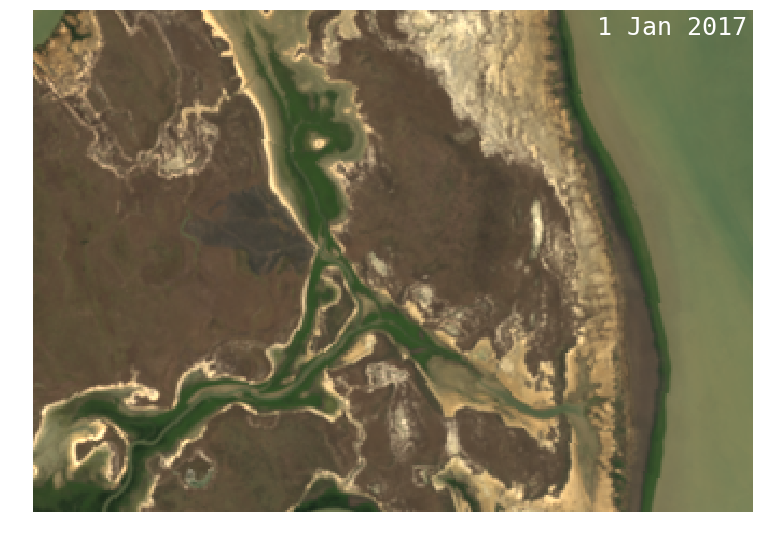

In [36]:
# Produce time series animation of red, green and blue bands
DEAPlotting.animated_timeseries(ds=combined_ds, output_path="/home/561/rt1527/Transfer/animated_timeseries_geomedian.gif", 
                                interval=1000, reflect_stand=2500, width_pixels=600) 

## Extract cloud-free clear Landsat observations from all sensors
Use the `load_clearlandsat` function to load Landsat observations and PQ data for multiple sensors (i.e. ls5, ls7, ls8), and return a single xarray dataset containing only observations that contain greater than a specified proportion of clear pixels. This uses `dask` to only load in the filtered observations, and results in a visually appealing time series of observations that are not affected by cloud!

In [ ]:
# Set the minimum proportion of clear pixels (pixels with no clouds or other nodata)
masked_prop=0.995

# Load in only clear Landsat observations with < 1% unclear values
# combined_ds = load_clearlandsat(dc=dc, query=query, masked_prop=masked_prop, mask_dict={'cloud_fmask': 'no_cloud', 'contiguous': True})  
combined_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, masked_prop=masked_prop)  
print(combined_ds)

# Plot first five time series images (just using the green band for simplicity):
combined_ds.green.isel(time=[1, 2, 3, 4, 5]).plot(col="time", robust=True)

## Plot entire time series as an animated GIF
The `animated_timeseries` function takes an xarray time series and exports a three band (e.g. true or false colour) GIF or MP4 animation showing changes in the landscape across time. Here, we plot the xarray as an animated GIF that includes a date annotation for each frame. We set the interval between the animation frames to 80 milliseconds, and set `reflect_stand=2500` to use a bright and vibrant colour stretch:

In [ ]:
# Remove dodgy images
times_to_drop = combined_ds.nir.loc['2006-09-26':'2006-11-20'].time.values
combined_ds_subset = combined_ds.drop(times_to_drop, dim="time")
combined_ds_subset

# Select only April to November
month = combined_ds_subset['time.month']
winter = (month > 3) & (month < 12)
combined_ds_subset = combined_ds_subset.where(winter, drop=True)
combined_ds_subset 


## Use ogr2ogr to clip mangroves database

In [66]:
for year in range(1985, 2018):
    
    # Extract extent for extraction
    left, bottom, right, top = combined_ds.extent.boundingbox

    # Set up OGR2OGR parameters
    out_data = "/g/data/r78/rt1527/mangroves/raw_data/out_{}.shp".format(year)
    in_data = "/g/data/r78/pjb552/MangChangePVFC_V5/AustraliaMangroveChange_v5.0.sqlite"
    timestep = "Mangroves_{}".format(year)

    # Run OGR2OGR
    !ogr2ogr -f "ESRI Shapefile" $out_data $in_data $timestep -spat $left $top $right $bottom -skipfailures

ERROR 1: Couldn't fetch requested layer 'Mangroves_1985'!
ERROR 1: Couldn't fetch requested layer 'Mangroves_1986'!
ERROR 1: Couldn't fetch requested layer 'Mangroves_2017'!


In [135]:
# out_data = "/g/data/r78/rt1527/mangroves/raw_data/out_{}.shp".format(2016)
# !ogrinfo -sql "SELECT SUM(OGR_GEOM_AREA) AS TOTAL_AREA FROM out_2016" $out_data

areas_m = [3099375, 3208125, 3127500, 3211250, 3317500, 3413125, 3483750, 3380625, 3773750, 4140000, 4322500,  4432500, 4525625, 4535000, 4903750, \
           4763125, 4839375, 4975625, 4998750, 5201250, 5128125, 5188125, 5083125, 5256250, 5281250, 5224375, 5352500, 5351250, 4385000]

areas_km = ["Mangroves:\n{0:.2f} sq km".format(area_m/1000000) for area_m in areas_m]

In [137]:
# Load modules
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import calendar

import shapefile as shp


def animated_timeseries(ds, output_path, bands=['red', 'green', 'blue'], reflect_stand=5000, width_pixels=300,
                        interval=100, font_size=25):
    
    """
    Takes an xarray time series and exports a three band (e.g. true or false colour) GIF or MP4 animation showing 
    changes in the landscape across time.
    
    Last modified: May 2018
    Author: Robbi Bishop-Taylor
    
    :param ds: 
        An xarray dataset with multiple time steps (i.e. multiple observations along the `time` dimension)
        
    :param output_path: 
        A string giving the output location and filename of the resulting animation. File extensions of '.gif'
        and '.mp4' are accepted.
        
    :param bands:
        Optional list of exactly three bands to be plotted, all of which must exist in the input xarray dataset.
        Defaults to `['red', 'green', 'blue']`.
        
    :param reflect_stand:
        An integer that allows you to have greater control over the contrast stretch by manually specifying a
        reflectance standardisation value. Low values (< 5000) result in brighter images. Defaults to 5000. 
        
    :param width_pixels:
        An integer defining the output width in pixels for the resulting animation. The height of the animation is
        set automatically based on the dimensions/ratio of the input xarray dataset. Defaults to 300 pixels wide.
        
    :param interval:
        An integer defining the milliseconds between each animation frame used to control the speed of the output
        animation. Higher values result in a slower animation. Defaults to 100 milliseconds between each frame.    
    
    :param font_size:
        An integer that allows you to set the font size for the animation's date annotation. Defaults to 25.   
        
    :example:
    
    >>> # Import modules
    >>> import datacube     
    >>> 
    >>> # Set up datacube instance
    >>> dc = datacube.Datacube(app='Time series animation')
    >>> 
    >>> # Set up spatial and temporal query.
    >>> query = {'x': (-191399.7550998943, -183399.7550998943),
    >>>          'y': (-1423459.1336905062, -1415459.1336905062),
    >>>          'measurements': ['red', 'green', 'blue'],
    >>>          'time': ('2013-01-01', '2018-01-01'),
    >>>          'crs': 'EPSG:3577'}
    >>> 
    >>> # Load in only clear Landsat observations with < 1% unclear values
    >>> combined_ds = load_clearlandsat(dc=dc, query=query, masked_prop=0.99)  
    >>>
    >>> # Produce animation of red, green and blue bands
    >>> animated_timeseries(ds=combined_ds, output_path="output.mp4", 
    >>>                     interval=80, width_pixels=600, reflect_stand=3000)   
        
    """
    
    # First test if there are three bands, and that all exist in dataset:
    if (len(bands) == 3) & all([(band in ds.data_vars) for band in bands]):        

        # Get height relative to a size of 10 inches width
        width_ratio = float(ds.sizes['x']) / float(ds.sizes['y'])
        height = 10 / width_ratio

        # Iterate through each timestep and add plot to list
        ims = []
        print('Generating animation with {} frames'.format(len(ds.time)))
        for i, timestep in enumerate(ds.time):
            
            # Set up plot
            fig, ax1 = plt.subplots()
            fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
            fig.set_size_inches(10, height, forward=True)
            plt.axis('off')

            # Get human-readable date info (e.g. "16 May 1990")
            year = timestep.time.dt.year.item()
            month = calendar.month_abbr[timestep.time.dt.month.item()]
            day = timestep.time.dt.day.item()
            date_desc = '{}'.format(year)

            # Select single timestep from the data array
            ds_i = ds.isel(time = i)

            # Create new three band array
            y, x = ds_i[bands[0]].shape
            rawimg = np.zeros((y, x, 3), dtype=np.float32)

            # Add xarray bands into three dimensional numpy array
            for band, colour in enumerate(bands):

                rawimg[:, :, band] = ds_i[colour].values

            # Stretch contrast using defined reflectance standardisation; defaults to 5000
            img_toshow = (rawimg / reflect_stand).clip(0, 1)

            # Plot image for each timestep and append to list
            left, bottom, right, top = ds.extent.boundingbox
            ax1.imshow(img_toshow, animated=True, extent=[left, right, bottom, top])

            # Set up text
            ax1.annotate(date_desc, 
                             xy=(1, 1), xycoords='axes fraction', 
                             xytext=(-5, -5), textcoords='offset points', 
                             horizontalalignment='right', verticalalignment='top', 
                             fontsize=50, color = "white") 
            
            ax1.annotate(areas_km[i], 
                 xy=(1, 1), xycoords='axes fraction', 
                 xytext=(-5, -60), textcoords='offset points', 
                 horizontalalignment='right', verticalalignment='top', 
                 fontsize=18, color = "white", family='monospace') 
            
            sf = shp.Reader("/g/data/r78/rt1527/mangroves/raw_data/{}.shp".format(np.max([year, 1987])))   
            for shape in sf.shapeRecords():
                
                if len(shape.shape.parts) == 1:
                    x = [i[0] for i in shape.shape.points]             
                    y = [i[1] for i in shape.shape.points]
                    ax1.plot(x, y, c="#ffff9e",  linewidth=1.3, scalex=False, scaley=False)
                    
                else:
                    for index in range(len(shape.shape.parts)):
                        try:
                            x = [i[0] for i in shape.shape.points[shape.shape.parts[index]:shape.shape.parts[index+1]]]
                            y = [i[1] for i in shape.shape.points[shape.shape.parts[index]:shape.shape.parts[index+1]]]
                        except:
                            x = [i[0] for i in shape.shape.points[shape.shape.parts[index]:]]
                            y = [i[1] for i in shape.shape.points[shape.shape.parts[index]:]]
                        ax1.plot(x, y, c="#ffff9e", linewidth=1.2, scalex=False, scaley=False)
            
#             Export and close
            file_suffix = year + (timestep.time.dt.month.item() / 12.0) + (day / 365.0)
            fig.savefig("/g/data/r78/rt1527/mangroves/out_data/{0:.4f}.jpg".format(file_suffix))
            plt.close()
#             ims.append(ax1)   
    
#         return(ims)
         
         
# Produce time series animation of red, green and blue bands
animated_timeseries(ds=combined_ds.isel(time=range(29)), output_path="/home/561/rt1527/Transfer/animated_timeseries_geomedian.gif", 
                    reflect_stand=5500, bands=['swir1', 'nir', 'green'], 
                    interval=1000, width_pixels=600, font_size=20)   



Generating animation with 29 frames


In [133]:
combined_ds.isel(time=range(29)).time

<xarray.DataArray 'time' (time: 29)>
array(['1988-01-01T00:00:00.000000000', '1989-01-01T00:00:00.000000000',
       '1990-01-01T00:00:00.000000000', '1991-01-01T00:00:00.000000000',
       '1992-01-01T00:00:00.000000000', '1993-01-01T00:00:00.000000000',
       '1994-01-01T00:00:00.000000000', '1995-01-01T00:00:00.000000000',
       '1996-01-01T00:00:00.000000000', '1997-01-01T00:00:00.000000000',
       '1998-01-01T00:00:00.000000000', '1999-01-01T00:00:00.000000000',
       '2000-01-01T00:00:00.000000000', '2001-01-01T00:00:00.000000000',
       '2002-01-01T00:00:00.000000000', '2003-01-01T00:00:00.000000000',
       '2004-01-01T00:00:00.000000000', '2005-01-01T00:00:00.000000000',
       '2006-01-01T00:00:00.000000000', '2007-01-01T00:00:00.000000000',
       '2008-01-01T00:00:00.000000000', '2009-01-01T00:00:00.000000000',
       '2010-01-01T00:00:00.000000000', '2011-01-01T00:00:00.000000000',
       '2012-01-01T00:00:00.000000000', '2013-01-01T00:00:00.000000000',
       '2014-0

In [143]:
!convert -loop 0 -delay 100 /g/data/r78/rt1527/mangroves/out_data/*.jpg /home/561/rt1527/Transfer/animation_geomedian.gif

In [ ]:
ds.time.isel(time=1).dt

In [141]:
# print('Exporting animation to {}'.format(output_path))
input_path = '/g/data/r78/rt1527/mangroves/out_data/*.jpg'
# output_path = '/home/561/rt1527/Transfer/animation.mp4'
# !ffmpeg -y -f image2 -pattern_type glob -i '/g/data/r78/rt1527/mangroves/out_data/*.jpg' /home/561/rt1527/Transfer/animation2.wmv
!ffmpeg -y -framerate 1 -pattern_type glob -i '/g/data/r78/rt1527/mangroves/out_data/*.jpg' -qscale 2 /home/561/rt1527/Transfer/animation_geomedian_noslc.wmv
# !convert -antialias -loop 0 -delay 5 $input_path $output_path   

ffmpeg version 3.4.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 4.8.2 (GCC) 20140120 (Red Hat 4.8.2-15)
  configuration: --prefix=/g/data/v10/public/modules/dea-env/20180405 --disable-doc --enable-shared --enable-static --extra-cflags='-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC -I/g/data/v10/public/modules/dea-env/20180405/include' --extra-cxxflags='=-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC' --extra-libs='-L/g/data/v10/public/modules/dea-env/20180405/lib -lz' --enable-pic --enable-gpl --enable-version3 --enable-hardcoded-tables --enable-avresample --enable-libfreetype --enable-gnutls --enable-libx264
  libavutil      55. 78.100 / 55. 78.100
  libavcodec     57.107.100 / 57.107.100
  libavformat    57. 83.100 / 57. 83.100
  libavdevice    57. 10.100 / 57. 10.100
  libavfilter     6.107.100 /  6.107.100
  libavresample   3.  7.  0 /  3.  7.  0
  libswscale      4.  8.100 /  4.  8.100
  libswresample   2.  9.100 /  2.  9.100
  libpostproc    54.  7.100 / 54.  7.100